This notebook is part of a multi-modal research project to predict road condition with SAR satelite images. This notebook is only for the pilot model.



In [ ]:
# Hugging Face API for download the model and for loading dataset
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets
# !pip install -q torchmetrics - Not used right now

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.6 MB/s eta 0:00:00


In [ ]:
# Mounting google drive
from google.colab import drive

drive.mount('/content/drive')

!ls /content/drive/My\ Drive/

Mounted at /content/drive
 backup  'Colab Notebooks'   sdu   UML-SemeterProject3-Gr10.drawio.png	 work


In [ ]:
import os
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
DATA_DIR = cwd + '/drive/MyDrive/work/multi-modal/data/sentinel-1-flipped-one-class'

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset(DATA_DIR, split="train")

Resolving data files:   0%|          | 0/402 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

In [ ]:
import pandas as pd
CSV_PATH = DATA_DIR + '/train/_classes.csv'
df = pd.read_csv(CSV_PATH)
df

,Pixel Value,Class
0,0,land
1,1,water


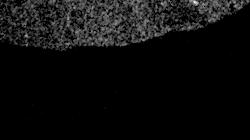

In [ ]:
example = train_dataset[0]
image = example["image"]
image

In [ ]:
image_file = image.filename
image_file

'/content/drive/MyDrive/work/MultiModal/data/sentinel-1-flipped-one-class/train/images/sentinel1_VH_20231009_png.rf.00c7d346066b9532fc0a9df86539462b.jpg'

In [ ]:
mask = image_file.replace('images', 'masks')
mask = mask.replace('.jpg', '_mask.png')
mask

'/content/drive/MyDrive/work/MultiModal/data/sentinel-1-flipped-one-class/train/masks/sentinel1_VH_20231009_png.rf.00c7d346066b9532fc0a9df86539462b_mask.png'

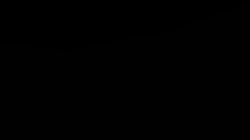

In [ ]:
from PIL import Image
Image.open(mask)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
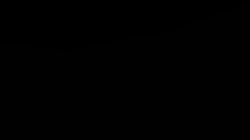

In [ ]:
### CHECK NUMPY ###
from numpy import asarray

np_mask = asarray(Image.open(mask))
np_mask

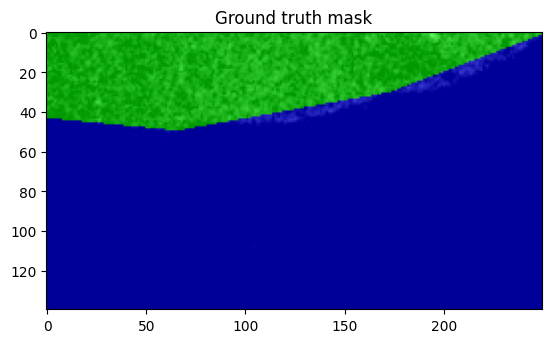

In [ ]:
### SANITY CHECK ###

import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax):
    water_color = np.array([0, 0, 1, 0.6]) # water
    land_color = np.array([0, 1, 0, 0.6]) # land
    h,w = mask.shape[-2:]
    mask_image = np.zeros((h, w, 4))
    mask_image[mask == 0] = land_color
    mask_image[mask == 1] = water_color
    ax.imshow(mask_image)

fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np_mask
show_mask(ground_truth_seg, axes)
axes.title.set_text("Ground truth mask")
axes.axis("on")

plt.show()

In [ ]:
### BOUNDING BOX UTIL FUNCTION ###
def get_bounding_box(ground_truth_map):
    # Extract indices of non-zero pixels (mask)
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return [0, 0, 0, 0]  # Return a default bbox if no mask is found

    # Get the bounding box coordinates
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    H, W = ground_truth_map.shape

    # Optionally adjust the bounding box (for padding or jitter)
    bbox = [x_min, y_min, x_max, y_max]
    return bbox

In [ ]:
import os
import numpy as np
from numpy import asarray
from torch.utils.data import Dataset
import torch
from PIL import Image


### CUSTOM DATASET ###
SIZE = (256, 256)

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Image
        image = item["image"]
        image_path = image.filename
        image = image.resize(SIZE)  # Resize image
        image_rgb = image.convert("RGB")  # Convert to RGB


        # Open the mask
        mask_path = image_path.replace("images", "masks").replace(".jpg", "_mask.png")
        mask = Image.open(mask_path)
        mask = mask.resize(SIZE)  # Resize mask
        mask_array = np.array(mask)  # Convert mask to numpy array

        # Convert mask to tensor
        ground_truth_mask = torch.from_numpy(mask_array).float()

        # Get the bounding box from the mask
        prompt = get_bounding_box(ground_truth_mask.numpy())  # Convert tensor to numpy for bounding box extraction
        inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}  # Remove batch dimension if present
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs





In [ ]:
# Download the processor from hugging face
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

SamProcessor:
- image_processor: SamImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "mask_pad_size": {
    "height": 256,
    "width": 256
  },
  "mask_size": {
    "longest_edge": 256
  },
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}


{
  "processor_class": "SamProcessor"
}

In [ ]:
# Create a training datset with the custom SAMDataset and prepare the data with
# the processor

# train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
# example = train_dataset[0]
# for k,v in example.items():
# print(k,v.shape)

In [ ]:
# Create Pytorch Dataloader

# from torch.utils.data import DataLoader
# train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

In [ ]:
# batch = next(iter(train_dataloader))
# for k,v in batch.items():
#  print(k,v.shape)

In [ ]:
# batch["ground_truth_mask"].shape

In [ ]:
from torch.utils.data import random_split, DataLoader
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size   # Remaining 20% for validation

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for both sets
train_dataloader = DataLoader(train_subset, batch_size=14, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=14,shuffle=False)

# Verify the split
print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")


Training set size: 320
Validation set size: 80


In [ ]:
### MODEL SETUP AND LOADING ###
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Train only the mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad = False

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
import os
import json
import logging
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch
from tqdm.auto import tqdm
from statistics import mean
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.functional import normalize

# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


### CUSTOM METRICS CALCULATION --- WORKING NOW ###
def compute_iou(pred_mask, ground_truth_mask, threshold=0.5):
    # Ensure tensors are on the same device and convert to binary masks
    pred_mask = (pred_mask > threshold).float()
    ground_truth_mask = (ground_truth_mask > threshold).float()

    # Compute intersection and union
    intersection = torch.sum(pred_mask * ground_truth_mask)
    union = torch.sum(pred_mask) + torch.sum(ground_truth_mask) - intersection

    # Avoid division by zero
    iou = intersection / (union + 1e-7)
    return iou.item()

def compute_dice_coefficient(pred_mask, ground_truth_mask, threshold=0.5):
    # Ensure tensors are on the same device and convert to binary masks
    pred_mask = (pred_mask > threshold).float()
    ground_truth_mask = (ground_truth_mask > threshold).float()

    # Compute intersection
    intersection = torch.sum(pred_mask * ground_truth_mask)

    # Compute Dice Coefficient
    dice = (2 * intersection) / (torch.sum(pred_mask) + torch.sum(ground_truth_mask) + 1e-7)
    return dice.item()

def compute_precision_recall(pred_mask, ground_truth_mask, threshold=0.5):
    # Ensure tensors are on the same device and convert to binary masks
    pred_mask = (pred_mask > threshold).float()
    ground_truth_mask = (ground_truth_mask > threshold).float()

    # True Positives
    tp = torch.sum(pred_mask * ground_truth_mask)

    # False Positives and False Negatives
    fp = torch.sum(pred_mask * (1 - ground_truth_mask))
    fn = torch.sum((1 - pred_mask) * ground_truth_mask)

    # Compute Precision and Recall
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)

    return precision.item(), recall.item()

### USE TORCHMETRICS -- NOT WORKING IN CURRENT SETUP ###
from torchmetrics.detection import IntersectionOverUnion
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall

### MODEL TRAINING CONFIG ###
class TrainingConfig:
    def __init__(self):
        # Determine base path for Google Colab
        self.base_path = '/content/drive/MyDrive/work/MultiModal/models'

        # Generate unique run identifier
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.run_id = f'run_{timestamp}'

        # Create run-specific directories
        self.run_dir = os.path.join(self.base_path, self.run_id)
        os.makedirs(self.run_dir, exist_ok=True)

        # Default configurations
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.num_epochs = 10
        self.learning_rate = 1e-4
        self.weight_decay = 0

        # Paths for saving
        self.model_save_path = os.path.join(self.run_dir, 'model_checkpoint.pth')
        self.log_path = os.path.join(self.run_dir, 'training_log.json')
        self.loss_plot_path = os.path.join(self.run_dir, 'training_loss.png')
        self.metrics_plot_path = os.path.join(self.run_dir, 'segmentation_metrics.png')

        # Print configuration details
        self.print_config()

    def print_config(self):
        print("Training Configuration:")
        print(f"Run ID: {self.run_id}")
        print(f"Device: {self.device}")
        print(f"Epochs: {self.num_epochs}")
        print(f"Learning Rate: {self.learning_rate}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Save Directory: {self.run_dir}")
def save_checkpoint(model, optimizer, config, epoch, metrics):
    try:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics
        }
        torch.save(checkpoint, config.model_save_path)
        logger.info(f"Checkpoint saved at epoch {epoch}")
    except Exception as e:
        logger.error(f"Error saving checkpoint: {e}")
import torch
from torchmetrics.detection import IntersectionOverUnion
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryPrecision, BinaryRecall


### MODEL VALIDATION ###
def validate(model, val_dataloader, criterion, config):
    # Initialize lists to store metrics
    val_losses = []
    val_iou_scores = []
    val_dice_scores = []
    val_precisions = []
    val_recalls = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation", unit='batch'):
            pixel_values = batch["pixel_values"].to(config.device)
            input_boxes = batch["input_boxes"].to(config.device)
            ground_truth_mask = batch["ground_truth_mask"].float().to(config.device)

            # Model inference
            outputs = model(
                pixel_values=pixel_values,
                input_boxes=input_boxes,
                multimask_output=False
            )

            # Predicted masks
            predicted_mask = outputs.pred_masks.squeeze(1)  # Remove channel dimension

            # Loss computation
            loss = criterion(predicted_mask, ground_truth_mask.unsqueeze(1))
            val_losses.append(loss.item())

            # Binarize masks for metrics
            binary_pred = (predicted_mask > 0.5).float()
            binary_gt = (ground_truth_mask > 0.5).float()

            # Compute custom metrics for each example in the batch
            for i in range(binary_pred.size(0)):  # Iterate over the batch
                # IoU
                iou = compute_iou(binary_pred[i], binary_gt[i])
                val_iou_scores.append(iou)

                # Dice Coefficient
                dice = compute_dice_coefficient(binary_pred[i], binary_gt[i])
                val_dice_scores.append(dice)

                # Precision and Recall
                precision, recall = compute_precision_recall(binary_pred[i], binary_gt[i])
                val_precisions.append(precision)
                val_recalls.append(recall)

    # Compute mean of the metrics
    mean_loss = np.mean(val_losses)
    mean_iou = np.mean(val_iou_scores)
    mean_dice = np.mean(val_dice_scores)
    mean_precision = np.mean(val_precisions)
    mean_recall = np.mean(val_recalls)

    print(f"Validation Metrics:")
    print(f"Loss: {mean_loss:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")

    return {
        'loss': mean_loss,
        'iou': mean_iou,
        'dice': mean_dice,
        'precision': mean_precision,
        'recall': mean_recall
    }



### TRAINING METRICS ###
def plot_training_metrics(metrics, config):
    plt.figure(figsize=(15, 10))

    # Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(metrics['train_losses'], label='Training Loss', marker='o')
    if 'val_losses' in metrics and metrics['val_losses']:
        plt.plot(metrics['val_losses'], label='Validation Loss', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Learning Rate
    plt.subplot(2, 2, 2)
    plt.plot(metrics['learning_rates'], label='Learning Rate', color='green')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    # IoU and Dice Coefficient
    plt.subplot(2, 2, 3)
    if 'iou' in metrics and metrics['iou']:
        plt.plot(metrics['iou'], label='IoU', marker='s', color='blue')
    if 'dice' in metrics and metrics['dice']:
        plt.plot(metrics['dice'], label='Dice Coefficient', marker='^', color='red')
    plt.title('Segmentation Performance Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    # Precision and Recall
    plt.subplot(2, 2, 4)
    if 'precision' in metrics and metrics['precision']:
        plt.plot(metrics['precision'], label='Precision', marker='o', color='purple')
    if 'recall' in metrics and metrics['recall']:
        plt.plot(metrics['recall'], label='Recall', marker='x', color='orange')
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(config.metrics_plot_path)
    plt.close()
    print(f"Training and segmentation metrics plot saved to {config.metrics_plot_path}")


In [ ]:
### TRAINING ###
def train(model, train_dataloader, config, val_dataloader=None, early_stopping=None):
    print(f"Starting training on {config.device}")
    model.to(config.device)

    optimizer = Adam(model.mask_decoder.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    seg_loss = torch.nn.BCEWithLogitsLoss()

    training_metrics = {
        'train_losses': [],
        'val_losses': [] if val_dataloader else [],
        'learning_rates': [],
        'iou': [],
        'dice': [],
        'precision': [],
        'recall': []
    }

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(config.num_epochs):
        model.train()
        epoch_train_losses = []

        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}", unit='batch')

        for batch in progress_bar:
            pixel_values = batch["pixel_values"].to(config.device)
            input_boxes = batch["input_boxes"].to(config.device)
            ground_truth_mask = batch["ground_truth_mask"].float().to(config.device)

            outputs = model(pixel_values=pixel_values, input_boxes=input_boxes, multimask_output=False)
            predicted_mask = outputs.pred_masks.squeeze(1)
            loss = seg_loss(predicted_mask, ground_truth_mask.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': optimizer.param_groups[0]['lr']})

        avg_train_loss = mean(epoch_train_losses)
        training_metrics['train_losses'].append(avg_train_loss)

        if val_dataloader:
            val_metrics = validate(model, val_dataloader, seg_loss, config)
            training_metrics['val_losses'].append(val_metrics['loss'])
            training_metrics['iou'].append(val_metrics['iou'])
            training_metrics['dice'].append(val_metrics['dice'])
            training_metrics['precision'].append(val_metrics['precision'])
            training_metrics['recall'].append(val_metrics['recall'])
            scheduler.step(val_metrics['loss'])

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if early_stopping and epochs_without_improvement >= early_stopping:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        training_metrics['learning_rates'].append(optimizer.param_groups[0]['lr'])
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

        if (epoch + 1) % 2 == 0:
            save_checkpoint(model, optimizer, config, epoch, training_metrics)

    return training_metrics


# Updated Logging function to include additional metrics
def save_training_log(config, metrics):
    try:
        log_data = {
            'configuration': {
                'device': config.device,
                'num_epochs': config.num_epochs,
                'learning_rate': config.learning_rate,
                'weight_decay': config.weight_decay,
                'run_id': config.run_id
            },
            'metrics': metrics
        }

        with open(config.log_path, 'w') as f:
            json.dump(log_data, f, indent=4)

        print(f"Training log saved to {config.log_path}")
    except Exception as e:
        print(f"Error saving training log: {e}")

In [ ]:
def main(num_epochs=10, learning_rate=1e-4, weight_decay=0, early_stopping=None):
    config = TrainingConfig()
    config.num_epochs = num_epochs
    config.learning_rate = learning_rate
    config.weight_decay = weight_decay

    print(f"Training for {num_epochs} epochs with LR={learning_rate}, WD={weight_decay}, Early Stopping={early_stopping}")

    training_metrics = train(
        model,
        train_dataloader,
        config,
        val_dataloader=val_dataloader,
        early_stopping=early_stopping
    )

    plot_training_metrics(training_metrics, config)
    save_training_log(config, training_metrics)


if __name__ == '__main__':
  # main(num_epochs=5, early_stopping=3) # Test run
  # main(num_epochs=20)
  # main(num_epochs=40)
  # main(num_epochs=60)
  # main(num_epochs=80)
  # main(num_epochs=100)
  # main(num_epochs=150)
  # main(num_epochs=200)
  ### --- ###
  main(num_epochs=1000, early_stopping=5)

Training Configuration:
Run ID: run_20241201_184309
Device: cuda
Epochs: 10
Learning Rate: 0.0001
Weight Decay: 0
Save Directory: /content/drive/MyDrive/work/MultiModal/models/run_20241201_184309
Training for 1000 epochs with LR=0.0001, WD=0, Early Stopping=5
Starting training on cuda


Epoch 1/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.1197
Mean IoU: 0.6172
Mean Dice Coefficient: 0.6542
Mean Precision: 0.6587
Mean Recall: 0.6723
Epoch 1, Train Loss: 0.1496


Epoch 2/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.1824
Mean IoU: 0.6009
Mean Dice Coefficient: 0.6396
Mean Precision: 0.6123
Mean Recall: 0.7193
Epoch 2, Train Loss: 0.0844


Epoch 3/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.1069
Mean IoU: 0.6404
Mean Dice Coefficient: 0.6733
Mean Precision: 0.6726
Mean Recall: 0.6907
Epoch 3, Train Loss: 0.0859


Epoch 4/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.1049
Mean IoU: 0.6225
Mean Dice Coefficient: 0.6544
Mean Precision: 0.6716
Mean Recall: 0.6496
Epoch 4, Train Loss: 0.0670


Epoch 5/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0695
Mean IoU: 0.6604
Mean Dice Coefficient: 0.6838
Mean Precision: 0.7018
Mean Recall: 0.6766
Epoch 5, Train Loss: 0.0512


Epoch 6/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.1048
Mean IoU: 0.6489
Mean Dice Coefficient: 0.6793
Mean Precision: 0.6801
Mean Recall: 0.7026
Epoch 6, Train Loss: 0.0596


Epoch 7/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0560
Mean IoU: 0.6720
Mean Dice Coefficient: 0.6996
Mean Precision: 0.7072
Mean Recall: 0.6988
Epoch 7, Train Loss: 0.0378


Epoch 8/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0353
Mean IoU: 0.6848
Mean Dice Coefficient: 0.7077
Mean Precision: 0.7128
Mean Recall: 0.7061
Epoch 8, Train Loss: 0.0254


Epoch 9/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0281
Mean IoU: 0.6869
Mean Dice Coefficient: 0.7092
Mean Precision: 0.7173
Mean Recall: 0.7036
Epoch 9, Train Loss: 0.0220


Epoch 10/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0294
Mean IoU: 0.6865
Mean Dice Coefficient: 0.7087
Mean Precision: 0.7135
Mean Recall: 0.7071
Epoch 10, Train Loss: 0.0200


Epoch 11/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0283
Mean IoU: 0.6879
Mean Dice Coefficient: 0.7097
Mean Precision: 0.7133
Mean Recall: 0.7087
Epoch 11, Train Loss: 0.0190


Epoch 12/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0265
Mean IoU: 0.6880
Mean Dice Coefficient: 0.7096
Mean Precision: 0.7130
Mean Recall: 0.7091
Epoch 12, Train Loss: 0.0181


Epoch 13/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0255
Mean IoU: 0.6893
Mean Dice Coefficient: 0.7104
Mean Precision: 0.7145
Mean Recall: 0.7089
Epoch 13, Train Loss: 0.0174


Epoch 14/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0225
Mean IoU: 0.6911
Mean Dice Coefficient: 0.7116
Mean Precision: 0.7167
Mean Recall: 0.7086
Epoch 14, Train Loss: 0.0167


Epoch 15/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0238
Mean IoU: 0.6900
Mean Dice Coefficient: 0.7110
Mean Precision: 0.7160
Mean Recall: 0.7082
Epoch 15, Train Loss: 0.0162


Epoch 16/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0231
Mean IoU: 0.6899
Mean Dice Coefficient: 0.7109
Mean Precision: 0.7142
Mean Recall: 0.7100
Epoch 16, Train Loss: 0.0157


Epoch 17/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0210
Mean IoU: 0.6908
Mean Dice Coefficient: 0.7114
Mean Precision: 0.7177
Mean Recall: 0.7075
Epoch 17, Train Loss: 0.0154


Epoch 18/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0249
Mean IoU: 0.6882
Mean Dice Coefficient: 0.7098
Mean Precision: 0.7113
Mean Recall: 0.7112
Epoch 18, Train Loss: 0.0149


Epoch 19/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0218
Mean IoU: 0.6909
Mean Dice Coefficient: 0.7115
Mean Precision: 0.7146
Mean Recall: 0.7106
Epoch 19, Train Loss: 0.0145


Epoch 20/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0225
Mean IoU: 0.6903
Mean Dice Coefficient: 0.7110
Mean Precision: 0.7132
Mean Recall: 0.7115
Epoch 20, Train Loss: 0.0143


Epoch 21/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0217
Mean IoU: 0.6909
Mean Dice Coefficient: 0.7114
Mean Precision: 0.7136
Mean Recall: 0.7117
Epoch 21, Train Loss: 0.0139


Epoch 22/1000:   0%|          | 0/23 [00:00<?, ?batch/s]

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Metrics:
Loss: 0.0212
Mean IoU: 0.6912
Mean Dice Coefficient: 0.7115
Mean Precision: 0.7143
Mean Recall: 0.7112
Early stopping triggered at epoch 22
Training and segmentation metrics plot saved to /content/drive/MyDrive/work/MultiModal/models/run_20241201_184309/segmentation_metrics.png
Training log saved to /content/drive/MyDrive/work/MultiModal/models/run_20241201_184309/training_log.json


In [ ]:
### INFERENCE

# Test inference
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import SamModel
from torchvision import transforms

# Load pre-trained model and checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-base")
model_name = "model_checkpoint.pth"
checkpoint_path = cwd + "/drive/MyDrive/work/multi-modal/models/run_20241201_130943/" + model_name
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

<ipython-input-24-10c37053324b>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

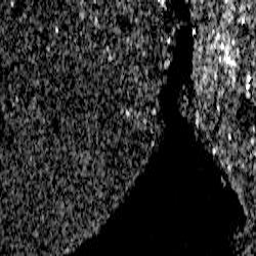

In [ ]:
# Test image index and dataset
idx = 13
test_image = train_dataset[idx]["image"]
test_image = test_image.resize((256, 256))
test_image

mask_file_name = train_dataset[idx]["image"].filename.replace("images", "masks").replace(".jpg", "_mask.png")
test_mask = Image.open(mask_file_name).resize((256, 256))
test_image

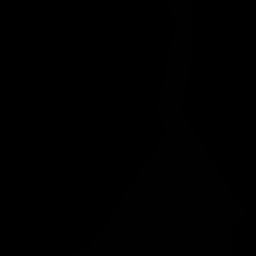

In [ ]:
test_mask

In [ ]:
# Convert the ground truth mask to numpy array
ground_truth_mask = np.array(test_mask)

# Get bounding box from ground truth mask
prompt = get_bounding_box(ground_truth_mask)
# get box prompt

prompt = get_bounding_box(ground_truth_mask)

# Prepare input image and bounding box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k, v in inputs.items():
    print(k, v.shape)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    # Perform inference
    outputs = model(**inputs, multimask_output=True)

# Apply sigmoid to convert logits to probabilities
tl_sam_seg_prob = torch.sigmoid(outputs.pred_masks[0, 0, :, :])  # Corrected indexing

# Convert probabilities to binary mask using a threshold
tl_sam_seg = (tl_sam_seg_prob > 0.5).cpu().numpy().squeeze()

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [ ]:
print("Shape of pred_masks:", outputs.pred_masks.shape)

Shape of pred_masks: torch.Size([1, 1, 3, 256, 256])


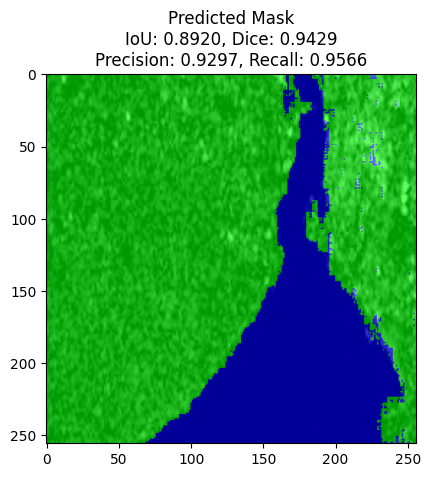

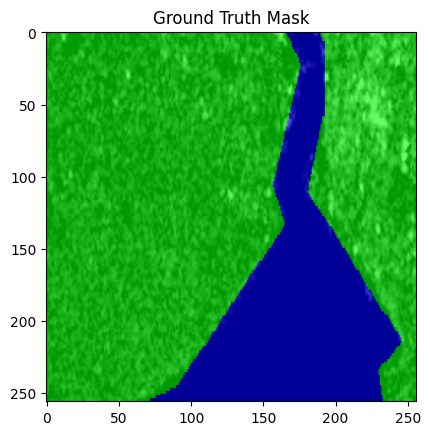

In [ ]:
# Convert the ground truth mask to a tensor
ground_truth_mask = torch.tensor(np.array(test_mask), dtype=torch.float32).to(device)

# Prepare image and box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt").to(device)

### PERFORM INTERFERCE ###
model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# Apply sigmoid to convert logits to probabilities
tl_sam_seg_prob = torch.sigmoid(outputs.pred_masks[0, 0, 0])
tl_sam_seg_prob = tl_sam_seg_prob.cpu().numpy().squeeze()

# Convert probabilities to binary mask (0 or 1) for thresholding
tl_sam_seg = (tl_sam_seg_prob > 0.5).astype(np.uint8)

# Convert the predicted mask to a PyTorch tensor for metric calculations
pred_mask_tensor = torch.tensor(tl_sam_seg, dtype=torch.float32).to(device)

# Compute metrics
iou = compute_iou(pred_mask_tensor, ground_truth_mask)
dice = compute_dice_coefficient(pred_mask_tensor, ground_truth_mask)
precision, recall = compute_precision_recall(pred_mask_tensor, ground_truth_mask)

# Plot predicted mask
fig, ax_pred = plt.subplots()
ax_pred.imshow(np.array(test_image))
show_mask(tl_sam_seg, ax_pred)  # Assuming show_mask is already defined
ax_pred.title.set_text(f"Predicted Mask\nIoU: {iou:.4f}, Dice: {dice:.4f}\nPrecision: {precision:.4f}, Recall: {recall:.4f}")
ax_pred.axis("on")

# Plot ground truth mask
fig, ax_gt = plt.subplots()
ax_gt.imshow(np.array(test_image))
show_mask(np.array(test_mask), ax_gt)
ax_gt.title.set_text("Ground Truth Mask")
ax_gt.axis("on")

plt.show()


In [ ]:
import os
import torch
import json
from PIL import Image
import numpy as np
from transformers import SamModel
import matplotlib.pyplot as plt

# Assuming compute_iou, compute_dice_coefficient, compute_precision_recall, and processor are already defined
device = "cuda" if torch.cuda.is_available() else "cpu"
model_dir = "/content/drive/MyDrive/work/multi-modal/models"
output_dir = "/content/drive/MyDrive/work/multi-modal/experiment"
os.makedirs(output_dir, exist_ok=True)

experiment_results = []

# Load 10 (3 for testing) test images and corresponding masks
test_images = [train_dataset[idx]["image"].resize((256, 256)) for idx in range(20)]
test_masks = [
    Image.open(train_dataset[idx]["image"].filename.replace("images", "masks").replace(".jpg", "_mask.png")).resize((256, 256))
    for idx in range(20)
]

# Iterate over all model directories
for run_folder in os.listdir(model_dir):
    if run_folder.startswith("run_"):
        run_path = os.path.join(model_dir, run_folder)
        checkpoint_path = os.path.join(run_path, "model_checkpoint.pth")
        training_log_path = os.path.join(run_path, "training_log.json")

        print(f"Processing {run_folder}...")

        # Load model and training log
        model = SamModel.from_pretrained("facebook/sam-vit-base")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

        # Load training log for epoch info
        try:
            with open(training_log_path, 'r') as f:
                training_log = json.load(f)
            num_epochs = training_log.get("configuration", {}).get("num_epochs", "unknown")
        except FileNotFoundError:
            num_epochs = "unknown"

        if num_epochs == "unknown":
            print(f"Warning: Epoch info not found for {run_folder}. Using -1 as placeholder.")
            num_epochs = -1  # Use -1 for unknown epochs

        model.eval()
        run_metrics = {"run": run_folder, "num_epochs": num_epochs, "metrics": []}

        with torch.no_grad():
            for idx, (test_image, test_mask) in enumerate(zip(test_images, test_masks)):
                print(f"  Running inference on image {idx + 1}/10...")

                ground_truth_mask = torch.tensor(np.array(test_mask), dtype=torch.float32).to(device)
                prompt = get_bounding_box(np.array(test_mask))
                inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt").to(device)

                outputs = model(**inputs, multimask_output=False)
                pred_mask_prob = torch.sigmoid(outputs.pred_masks[0, 0, 0])
                pred_mask = (pred_mask_prob > 0.5).float().to(device)

                # Calculate metrics
                iou = compute_iou(pred_mask, ground_truth_mask)
                dice = compute_dice_coefficient(pred_mask, ground_truth_mask)
                precision, recall = compute_precision_recall(pred_mask, ground_truth_mask)

                run_metrics["metrics"].append({
                    "image_idx": idx,
                    "iou": iou,
                    "dice": dice,
                    "precision": precision,
                    "recall": recall
                })

        experiment_results.append(run_metrics)

# Save metrics to JSON
output_path = os.path.join(output_dir, "metrics_results.json")
with open(output_path, "w") as f:
    json.dump(experiment_results, f, indent=4)

print(f"Experiment complete. Metrics saved to '{output_path}'.")


Processing run_20241201_130943...


<ipython-input-76-15d4e9707c02>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


  Running inference on image 1/10...
  Running inference on image 2/10...
  Running inference on image 3/10...
  Running inference on image 4/10...
  Running inference on image 5/10...
  Running inference on image 6/10...
  Running inference on image 7/10...
  Running inference on image 8/10...
  Running inference on image 9/10...
  Running inference on image 10/10...
  Running inference on image 11/10...
  Running inference on image 12/10...
  Running inference on image 13/10...
  Running inference on image 14/10...
  Running inference on image 15/10...
  Running inference on image 16/10...
  Running inference on image 17/10...
  Running inference on image 18/10...
  Running inference on image 19/10...
  Running inference on image 20/10...
Processing run_20241201_131440...
  Running inference on image 1/10...
  Running inference on image 2/10...
  Running inference on image 3/10...
  Running inference on image 4/10...
  Running inference on image 5/10...
  Running inference on image 6

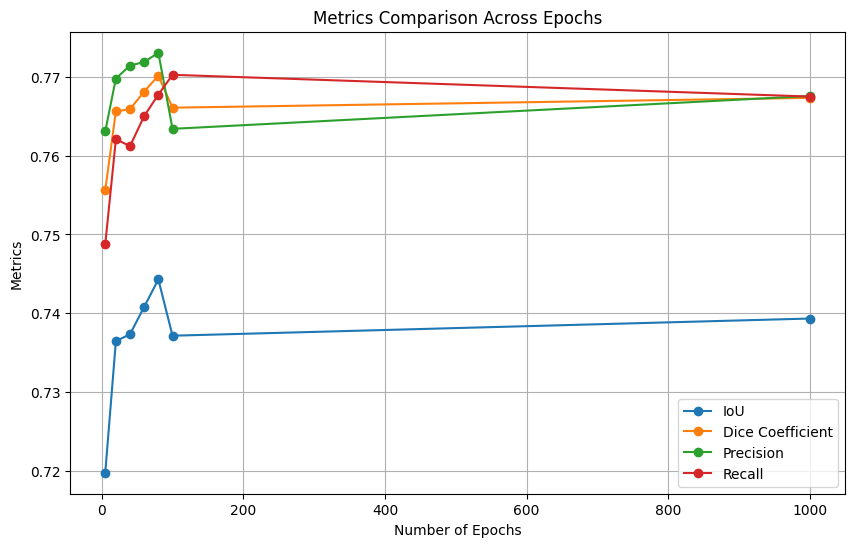

In [ ]:
# Load results from metrics JSON
output_path = "/content/drive/MyDrive/work/multi-modal/experiment/metrics_results.json"
with open(output_path, "r") as f:
    results = json.load(f)

# Prepare lists to store metrics and num_epochs
num_epochs = []
iou_scores, dice_scores, precision_scores, recall_scores = [], [], [], []

for run in results:
    run_name = run["run"]
    num_epochs_value = run.get("num_epochs", -1)  # Default to -1 if num_epochs is missing -- which shouldn't

    # Append the num_epochs to the list
    num_epochs.append(num_epochs_value)

    # Calculate mean metrics for each run
    iou = np.mean([m["iou"] for m in run["metrics"]])
    dice = np.mean([m["dice"] for m in run["metrics"]])
    precision = np.mean([m["precision"] for m in run["metrics"]])
    recall = np.mean([m["recall"] for m in run["metrics"]])

    # Append the metrics
    iou_scores.append(iou)
    dice_scores.append(dice)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Ensure num_epochs and metrics are sorted by num_epochs
sorted_indices = np.argsort(num_epochs)
num_epochs = np.array(num_epochs)[sorted_indices]
iou_scores = np.array(iou_scores)[sorted_indices]
dice_scores = np.array(dice_scores)[sorted_indices]
precision_scores = np.array(precision_scores)[sorted_indices]
recall_scores = np.array(recall_scores)[sorted_indices]

# Plot metrics
plt.figure(figsize=(10, 6))
plt.plot(num_epochs, iou_scores, label="IoU", marker="o")
plt.plot(num_epochs, dice_scores, label="Dice Coefficient", marker="o")
plt.plot(num_epochs, precision_scores, label="Precision", marker="o")
plt.plot(num_epochs, recall_scores, label="Recall", marker="o")

plt.xlabel("Number of Epochs")
plt.ylabel("Metrics")
plt.title("Metrics Comparison Across Epochs")
plt.legend()
plt.grid(True)
plt.show()
